In [1]:
import sys
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
import dill

In [2]:
raw_data = pd.read_csv(r'data/new_graph.csv', sep='\t')
raw_data = raw_data.as_matrix()

C:\Users\Coco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [3]:
raw_data

array([[         1,          2,          1, 1095183096],
       [         3,          4,          1, 1095183096],
       [         5,          6,          1, 1095183096],
       ...,
       [        15,         11,      33451, 1115253096],
       [        15,         11,      33451, 1115253096],
       [        15,         11,      33452, 1115253696]], dtype=int64)

### Network visualization

C:\Users\Coco\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


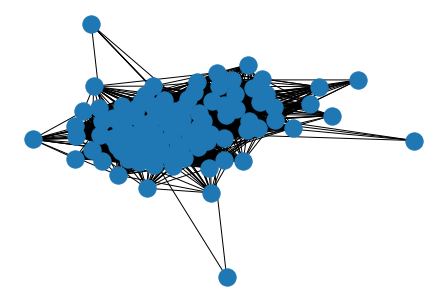

In [4]:
# generate the graph
graph = nx.Graph()

for row in raw_data:
    graph.add_edge(row[0], row[1])
    
nx.draw(graph)
plt.show()

### Network properties

In [5]:
N_nodes = graph.number_of_nodes()
print(f'Nr of nodes: {N_nodes}')

L_edges = graph.number_of_edges()
print(f'Nr of edges: {L_edges}')

p_density = nx.density(graph)
print(f'Link density: {p_density}')

D_mean = (2 * L_edges) / N_nodes
print(f'E[D]: {D_mean}')

D_var = (2 * L_edges * (N_nodes * (N_nodes - 1) - 2 * L_edges)) / (N_nodes * N_nodes * (N_nodes + 1))
print(f'Var[D]: {D_var}')

Nr of nodes: 96
Nr of edges: 2539
Link density: 0.5567982456140351
E[D]: 52.895833333333336
Var[D]: 22.96015446019473


### Degree distribution

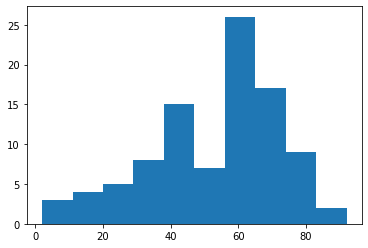

In [6]:
degrees = [num for i,num in graph.degree()]
plt.hist(degrees)
plt.show()

### Infection simulation (utils)

In [7]:
def isolate_nodes(nodes, percent):
    size = int(nodes * percent / 100)
    _list = random.sample(range(nodes), size)
    return dict.fromkeys(_list, True)

def get_delay_timestamp(day):
    return day * 144

### Infection simulation (multiprocessing)

In [8]:
import workers
from multiprocessing import Pool
from timeit import default_timer as timer

In [9]:
if __name__ == '__main__':
    _processes = 10
    _isolated = isolate_nodes(N_nodes, 30)
    _delay = get_delay_timestamp(7)
    _infection_rate = 0.1
    _incubate_delay = get_delay_timestamp(7)
    _recover_delay = get_delay_timestamp(14)
    p = Pool(processes = _processes)
    _start = timer()
    # res = p.starmap(workers.simulate_infection, [(i, raw_data, N_nodes, []) for i in range(1, N_nodes + 1)])
    res = p.starmap(workers.simulate_infection, [(i, raw_data, N_nodes, _isolated, _delay, _infection_rate, _incubate_delay, _recover_delay) for i in range(1, N_nodes + 1)])
    p.close()
    p.join()
    _end = timer()
    print(f'simulation time: {_end-_start}')

simulation time: 67.4542927


In [10]:
infections_list = []
recover_list = []
for result in res:
    infections_list.append(result[0])
    recover_list.append(result[1])
    
infections = np.array(infections_list)
recovered = np.array(recover_list)
infections_mean = np.mean(infections, axis=0)
recovered_mean = np.mean(recovered, axis=0)
infections_var = np.var(infections, axis=0)

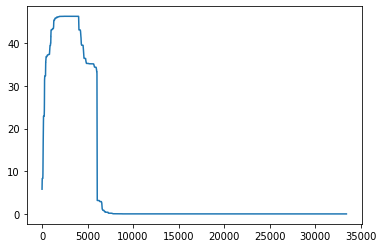

In [11]:
plt.plot(infections_mean)

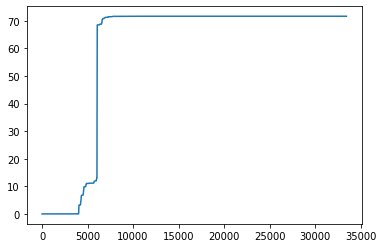

In [12]:
plt.plot(recovered_mean)